In [808]:
%pip install --upgrade pip
%pip install pandas numpy openpyxl matplotlib seaborn
import pandas,numpy,os,re,datetime,random,itertools

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Paramètres

In [809]:
PERIODE = [2012,2022]

# Chargement des données

In [810]:
def get_indice_name(file_name:str)->str:
    """Cette fonction permet d'obtenir le nom de l'indice 
    à partir du code de ce dernier
    """
    # Nous définissons les détails de chaque indice 
    # dans une liste de dictionnaires
    # Avec les clés : code et name
    indices = [
            {'code':'^FCHI','name':'CAC40'},
            {'code':'^GSPC','name':'S&P 500'},
            {'code':'^HSI','name':'Hang Seng'},
            {'code':'MSCI','name':'MSCI Emerging Markets'},
            {'code':'^BVSP','name':'Sao Paolo'},
            ]
    
    # Nous parcourons la liste pour trouver 
    # le dictionnaire correspondant
    # à l'indice dont le code correspond à file_name (paramètre)
    for indice in indices:
        if indice['code'] in file_name:
            # Nous renvoyons le nom de l'indice correspondant
            # Lorsqu'il est trouvé dans la liste
            return indice['name']
    # Sinon nous renvoyons le file_name (paramètre)
    return file_name 


def load_data(directory:str)->dict:
    # Nous définissons un dictionnaire
    data = dict()
    # Nous lisons tous les fichiers présents dans le directory (paramètre)
    for file_path in os.listdir(directory):
        try:
            # Si MSCI alors le fichier est différent (séparateur ;)
            if "MSCI" in file_path:
                # Nous lisons le fichier dans un dataframe
                # En utilisant le séparateur ;
                df = pandas.read_csv(f'{directory}/{file_path}', sep=';') 
            else:
                # Nous lisons le fichier dans un dataframe
                # Avec les paramètres par défaut
                df = pandas.read_csv(f'{directory}/{file_path}')
            # Nous ajoutons le dataframe dans le dictionnaire
            data[get_indice_name(file_path)] = df
        except Exception as error:
            # S'il y a une erreur, nous affichons le message
            # Mais nous ne levons pas d'exception
            # Ceci permet de continuer le chargement
            print(error)
    # Nous renvoyons le dictionnaire avec toutes les données
    return data

In [811]:
data = load_data('./input')

'utf-8' codec can't decode byte 0x80 in position 3131: invalid start byte


In [812]:
print(data)

{'Hang Seng':             Date          Open          High           Low         Close  \
0     1986-12-31   2568.300049   2568.300049   2568.300049   2568.300049   
1     1987-01-01           NaN           NaN           NaN           NaN   
2     1987-01-02   2540.100098   2540.100098   2540.100098   2540.100098   
3     1987-01-05   2552.399902   2552.399902   2552.399902   2552.399902   
4     1987-01-06   2583.899902   2583.899902   2583.899902   2583.899902   
...          ...           ...           ...           ...           ...   
9234  2023-05-19  19535.490234  19610.720703  19352.810547  19450.570313   
9235  2023-05-22  19479.060547  19806.439453  19410.070313  19678.169922   
9236  2023-05-23  19713.460938  19769.140625  19363.500000  19431.250000   
9237  2023-05-24  19279.390625  19304.199219  19046.800781  19115.929688   
9238  2023-05-25  18930.230469  18930.230469  18620.839844  18746.919922   

         Adj Close        Volume  
0      2568.300049  0.000000e+00  
1  

# Traitement des données

In [813]:
def clean_data(data:dict)->dict:
    # Nous définissons un nouveau dictionnaire
    new_dict = dict()
    # Nous parcourons les données
    for header,content in data.items():
        # Nous appliquonns le type DataFrame
        # au contenu, afin de prévenir les erreurs
        content = pandas.DataFrame(content)
        # Nous vérifions le format du champ date
        if re.match("^\d{2}/\d{2}/\d{2}$",content.Date[0]):
            # Nous transformons le champ mm/dd/yy en yyyy-mm-dd
            content.Date = content.Date.apply(
                lambda x: pandas.to_datetime(x, format='%m/%d/%y').strftime('%Y-%m-%d')
            )
        elif re.match("^\d{2}/\d{2}/\d{4}$",content.Date[0]):
            # Nous transformons le champ mm/dd/yyyy en yyyy-mm-dd
            content.Date = content.Date.apply(
                lambda x: pandas.to_datetime(x, format='%m/%d/%Y').strftime('%Y-%m-%d')
            )

        for column_name in content.columns:
            # Si le nom de la colonne comporte Close ou Date
            if column_name.strip().upper() in ['CLOSE','DATE']:
                # Si la colonne est date
                if column_name.strip().upper() in ['DATE']:
                    # Nous trions les dates par ordre croissant
                    content = content.sort_values(column_name, ascending=True)
                    # Nous ajoutons en indices la colonne date
                    content = content.set_index(column_name)
                    # Nous convertissons le type en datetime
                    content.index = pandas.to_datetime(content.index)
                else:
                    # Nous enregistrons le nom de la colonne close
                    close_column = [column_name]
        

        # Nous gardons uniquement la colonne close
        content = content.loc[:, close_column]
    
        # Nous supprimons les lignes vides
        content = content.dropna()

        new_dict[header] = content
    return new_dict

In [814]:
cleaned_data = clean_data(data)

# Calcul des statistiques

In [815]:
def statistics(cleaned_data:dict)->dict:
    # Nous allons calculer le rendement annuel
    # prix de clôture du dernier jour de l'année divisé par
    # prix de clôture du premier jour de l'année)
    results = dict()
    for header,df in cleaned_data.items():
        stats = list()
        first = True
        for index, row in df.iterrows():
            if first:
                first_day_price = row[0]
                week = index.week
                first = False
            # Si l'année change
            if index.week != week:
                # Nous calculons le rendement annuel
                stats.append({index:(last_day_price/first_day_price)-1})
                first_day_price = row[0]
                week = index.week
            last_day_price = row[0]        
        results[header] = stats
    return results

In [816]:
statistics = statistics(cleaned_data)

In [817]:
print(statistics)

{'Hang Seng': [{Timestamp('1987-01-05 00:00:00'): -0.010980006409679444}, {Timestamp('1987-01-12 00:00:00'): 0.0036436488626694352}, {Timestamp('1987-01-19 00:00:00'): -0.027649166969910377}, {Timestamp('1987-01-26 00:00:00'): 0.015809754927860187}, {Timestamp('1987-02-02 00:00:00'): 0.027733114521753865}, {Timestamp('1987-02-09 00:00:00'): 0.03419470395928381}, {Timestamp('1987-02-16 00:00:00'): 0.009875833542364987}, {Timestamp('1987-02-23 00:00:00'): 0.022161093896899242}, {Timestamp('1987-03-02 00:00:00'): -0.0003821111497047669}, {Timestamp('1987-03-09 00:00:00'): -0.03306497231794092}, {Timestamp('1987-03-16 00:00:00'): -0.035172299832252674}, {Timestamp('1987-03-23 00:00:00'): 0.04157926128454914}, {Timestamp('1987-03-30 00:00:00'): -0.005224977433727074}, {Timestamp('1987-04-07 00:00:00'): -0.03419939650133008}, {Timestamp('1987-04-13 00:00:00'): 0.03816562947803348}, {Timestamp('1987-04-21 00:00:00'): 0.004503745594657271}, {Timestamp('1987-04-27 00:00:00'): -0.002137467461292

In [818]:
dataframes = pandas.DataFrame()
for header,yearly_return in statistics.items():
    xs = list()
    ys = list()
    for a in yearly_return:
        for y,x in a.items():
            ys.append(y)
            xs.append(x)
    dataframes[header]=pandas.DataFrame(xs,index=ys)

dataframes.to_excel('output.xlsx')

print(dataframes)

            Hang Seng     CAC40   S&P 500
1987-01-05  -0.010980       NaN  0.007275
1987-01-12   0.003644       NaN  0.025933
1987-01-19  -0.027649       NaN  0.022973
1987-01-26   0.015810       NaN  0.002822
1987-02-02   0.027733       NaN  0.016580
...               ...       ...       ...
2023-04-24  -0.034006  0.010512 -0.004288
2023-05-02  -0.003275 -0.010874       NaN
2023-05-08   0.005794  0.006736 -0.007587
2023-05-15  -0.032999 -0.003502 -0.003393
2023-05-22  -0.026066  0.009942  0.013466

[1899 rows x 3 columns]


# Construction des portefeuilles

In [819]:
def generate_weights(indexes_number):
    # Define the number of indexes and the step value
    num_indexes = indexes_number
    step = 0.05

    # Define the range of percentages to generate
    min_percent = 0
    max_percent = 1
    percent_range = range(int(min_percent/step), int(max_percent/step) + 1)

    # Generate all combinations of percentages using itertools.product()
    weight_combinations = itertools.product(percent_range, repeat=num_indexes)

    return [list(round(w*step,2) for w in weights) for weights in weight_combinations if sum(weights)*step == 1.0]


In [820]:
merged_df = dataframes.dropna()

# keep only rows with index between PERIODE
merged_df = merged_df[merged_df.index.year >= PERIODE[0]]
merged_df = merged_df[merged_df.index.year <= PERIODE[1]]

# Create a storage df
portfolios_df = pandas.DataFrame()
details = pandas.DataFrame()

weights_list = generate_weights(len(merged_df.columns))
for i,weights in enumerate(weights_list):
    # TO calculate the return of the portfolio,
    # we can use the weight
    # but to calculate the risk, we have to use covariance matrix
    returns = numpy.array([merged_df[mean_column] for mean_column in merged_df.columns])
    cov_matrix = numpy.cov(returns)
    # Portfolio standard deviation
    portfolio_std = numpy.sqrt(numpy.dot(numpy.dot(weights, cov_matrix), weights))
    # Calculate portfolio return
    portfolio_return = numpy.mean(numpy.dot(returns.T, weights))
    composition = str()
    portfolio_df = pandas.DataFrame({
        'risks':portfolio_std,
        'returns':portfolio_return,
        },index=[i])
    for weight,title in zip(weights,merged_df.columns):
        portfolio_df[title]=f"{round(weight*100)}%"
        composition += f"{title} : {round(weight*100)}%\n"
        if weight == 1.0:
            detail = pandas.DataFrame(
                {
                    'risks':portfolio_std,
                    'returns':portfolio_return,
                },
                index=[i]
            )
            detail["Étiquette"] = f"{title} : {round(weight*100)}%"
            details = pandas.concat([details,detail])

    portfolios_df = pandas.concat([portfolios_df,portfolio_df])


In [821]:
merged_df.describe().round(2).to_excel('statistics.xlsx')

# Calcul de la matrice de corrélation

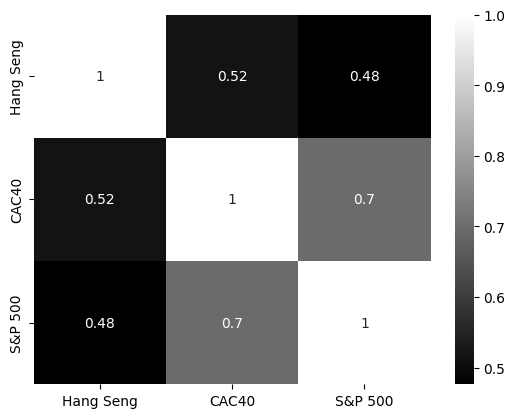

In [822]:
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = merged_df[merged_df.columns].corr()

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, cmap='gray', annot=True)


# Save the heatmap to file
import matplotlib.pyplot as plt
plt.savefig('heatmap.png')

# Find most relevant portfolio

In [823]:
# Initialize excel writer to draw charts later
writer = pandas.ExcelWriter('portfolio.xlsx')
portfolios_df.to_excel(writer,sheet_name="portfolios",index=False)

# Get the index label of the portfolio with the lowest risk
min_risk_portfolio = portfolios_df['risks'].idxmin()
min_risk_portfolio = portfolios_df.loc[[min_risk_portfolio]]
headers = min_risk_portfolio.drop(['risks', 'returns'], axis=1).columns
values =  min_risk_portfolio.drop(['risks', 'returns'], axis=1).values.tolist()[0]
etiquette = str()
for header,value in zip(headers,values):
    etiquette += f"{header} : {value}\n"
min_risk_portfolio["Étiquette"] = etiquette.rstrip("\n")
min_risk_portfolio = min_risk_portfolio.drop(headers, axis=1)


# Get the index label of the portfolio with the highest risk
max_return_portfolio = portfolios_df['returns'].idxmax()
max_return_portfolio = portfolios_df.loc[[max_return_portfolio]]
headers = max_return_portfolio.drop(['risks', 'returns'], axis=1).columns
values =  max_return_portfolio.drop(['risks', 'returns'], axis=1).values.tolist()[0]
etiquette = str()
for header,value in zip(headers,values):
    etiquette += f"{header} : {value}\n"
max_return_portfolio["Étiquette"] = etiquette.rstrip("\n")
max_return_portfolio = max_return_portfolio.drop(headers, axis=1)

# Get the index label of the portfolio with the best Sharpe ratio
best_sharpe_portfolio = (portfolios_df['returns']/portfolios_df['risks']).idxmax()
best_sharpe_portfolio = portfolios_df.loc[[best_sharpe_portfolio]]
headers = best_sharpe_portfolio.drop(['risks', 'returns'], axis=1).columns
values =  best_sharpe_portfolio.drop(['risks', 'returns'], axis=1).values.tolist()[0]
etiquette = str()
for header,value in zip(headers,values):
    etiquette += f"{header} : {value}\n"
best_sharpe_portfolio["Étiquette"] = etiquette.rstrip("\n")
best_sharpe_portfolio = best_sharpe_portfolio.drop(headers, axis=1)

# Select the rows corresponding to the selected portfolios
# selected_portfolios = portfolios_df.loc[[min_risk_portfolio, max_return_portfolio, best_sharpe_portfolio]]


details = pandas.concat([details,min_risk_portfolio, max_return_portfolio, best_sharpe_portfolio])
details.to_excel(writer,sheet_name="extremes",index=False)


writer.close()

# find the index of the row with the lowest risk for each return group
min_risk_idx = portfolios_df.groupby('returns')['risks'].idxmin()

# filter the dataframe to keep only the rows with the lowest risk for each return group
df = portfolios_df.loc[min_risk_idx]

# order the dataframe by "return"
df = df.sort_values(by='returns')

# filter out rows where the "risk" column is not in ascending order as well
df = df[df['risks'].diff().fillna(0) >= 0]


# reset the index of the dataframe
df = df.reset_index(drop=True)

df.to_excel(writer,sheet_name="cleaned",index=False)